In [52]:
#Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

In [53]:
# Haritalama için:
import folium
import plotly.express as px

In [54]:
# Grafik ayarlarını optimize etme
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [55]:
# Dosya Yükleme
from google.colab import files
uploaded = files.upload()

Saving OECD_PISA_data_2003-2018.csv to OECD_PISA_data_2003-2018 (2).csv


In [56]:
# Dosya Okuma
df = pd.read_csv(list(uploaded.keys())[0])

In [57]:
# Veriye İlk Bakış
print("Veri Setinin İlk 5 Satırı:")
display(df.head())

Veri Setinin İlk 5 Satırı:


,index,LOCATION,INDICATOR,SUBJECT,TIME,Value
0,0,AUS,PISAMATH,BOY,2003,527.000
1,1,AUS,PISAMATH,BOY,2006,527.000
2,2,AUS,PISAMATH,BOY,2009,519.000
3,3,AUS,PISAMATH,BOY,2012,510.115
4,4,AUS,PISAMATH,BOY,2015,497.000


Veri setindeki sütunlar:

--LOCATION: Ülke kodları (AUS, TUR, vb.)

--INDICATOR: PISA test türü (PISAMATH gibi)

--SUBJECT: Cinsiyet (BOY, GIRL, TOT - Toplam olabilir)

--TIME: Yıl

--Value: PISA Puanı

In [58]:
print("\nVeri Seti Bilgileri (Sütunlar ve Tipler):")
df.info()


Veri Seti Bilgileri (Sütunlar ve Tipler):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      2087 non-null   int64  
 1   LOCATION   2087 non-null   object 
 2   INDICATOR  2087 non-null   object 
 3   SUBJECT    2087 non-null   object 
 4   TIME       2087 non-null   int64  
 5   Value      2087 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 98.0+ KB


Bu komut(INFO), "Veri setim teknik olarak analize hazır mı?" sorusunun cevabını verir.


Ve bize şu 3 kritik sorunun cevabını verir:

--Veri setimde eksik (boş) bilgi var mı?

--Sütunlarımın veri tipleri doğru mu? (Örn: Sayı olması gereken bir yer yazı olarak mı kaydedilmiş?)

--Veri setim ne kadar büyük?

In [59]:
print("\nVeri Setinin Boyutu (Satır, Sütun):")
print(df.shape)


Veri Setinin Boyutu (Satır, Sütun):
(2087, 6)


Bu, veri setinde 2087 satır (gözlem/kayıt) ve 6 sütun (değişken) olduğu anlamına gelir.

**--Veri Temizleme (Data Cleaning)**:

--Bu aşamada gereksiz sütunları kaldırdık ve veriyi biraz daha tanımaya çalıştık.

In [60]:
# 'index' sütunu gereksiz görünüyor o nedenle onu çıkardık.
if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

In [61]:
# Tekrar eden satır var mı kontrol ettik.
print(f"Tekrar eden satır sayısı: {df.duplicated().sum()}")

Tekrar eden satır sayısı: 0


In [62]:
#null(eksik) değerler olup olmadığını kontrol ettik.
print(df.isnull().sum())

LOCATION     0
INDICATOR    0
SUBJECT      0
TIME         0
Value        0
dtype: int64


In [63]:
# Kategorik sütunlardaki benzersiz değerleri görmek istedik (Neleri analiz edebiliriz?).
print("\nBenzersiz 'INDICATOR' (Dersler):")
print(df['INDICATOR'].unique())

print("\nBenzersiz 'SUBJECT' (Cinsiyet/Grup):")
print(df['SUBJECT'].unique())

print("\nBenzersiz 'LOCATION' (Ülkeler - İlk 10):")
print(df['LOCATION'].unique()[:10])


Benzersiz 'INDICATOR' (Dersler):
['PISAMATH' 'PISAREAD' 'PISASCIENCE']

Benzersiz 'SUBJECT' (Cinsiyet/Grup):
['BOY' 'GIRL' 'TOT']

Benzersiz 'LOCATION' (Ülkeler - İlk 10):
['AUS' 'AUT' 'BEL' 'CAN' 'CZE' 'DNK' 'FIN' 'FRA' 'DEU' 'GRC']


In [64]:
# Her ülke (LOCATION) için kaç adet veri satırı olduğunu saydık.
ulke_sayilari = df['LOCATION'].value_counts()
print(ulke_sayilari)

LOCATION
AUS     54
BEL     54
CAN     54
DNK     54
CZE     54
FIN     54
FRA     54
ISL     54
DEU     54
GRC     54
HUN     54
ITA     54
IRL     54
JPN     54
KOR     54
BRA     54
MEX     54
NOR     54
NZL     54
POL     54
PRT     54
SWE     54
CHE     54
IDN     54
LUX     53
SVK     51
NLD     51
USA     51
TUR     51
ESP     51
OAVG    49
CHL     48
ISR     48
RUS     47
AUT     45
GBR     45
EST     45
SVN     45
LVA     30
COL     18
SGP      9
HKG      9
PER      9
TWN      9
MAC      9
CRI      9
LTU      9
Name: count, dtype: int64


Yukarıdaki komut (LOCATION), veri setinin dengeli olup olmadığını
veya hangi ülkelere odaklanmamız daha sağlıklı olacağını anlamak için çok önemlidir. Örneğin, sadece 9 verisi olan bir ülkeyle 54 verisi olan bir ülkeyi zaman serisi analizinde (yıllara göre değişim) karşılaştırmak yanıltıcı olabilir.

In [65]:
# Hangi dersten (INDICATOR) kaç veri satırı olduğunu saydık.
ders_sayilari = df['INDICATOR'].value_counts()
print(ders_sayilari)

INDICATOR
PISAREAD       787
PISAMATH       700
PISASCIENCE    600
Name: count, dtype: int64


PISAREAD (Okuma): 787 satır veri ile en çok veri bu alanda toplanmış.

PISAMATH (Matematik): 700 satır veri mevcut.

PISASCIENCE (Fen): 600 satır veri ile en az veri bu alanda.

Analiz yaparken veri sayılarının eşit olmadığını bilmek önemlidir. Örneğin, "Tüm derslerin ortalaması"nı aldığımızda, Okuma (Read) puanlarının ortalamayı daha fazla etkileyeceğini (ağırlığının fazla olduğunu) göz önünde bulundurmamız gerekir. Veri setimizde Fen (Science) verilerinin daha az olması, belki de bu testin bazı yıllarda veya bazı ülkelerde uygulanmadığına işaret edebilir.

In [66]:
# Cinsiyet/Grup (SUBJECT) dağılımı
cinsiyet_sayilari = df['SUBJECT'].value_counts()
print(cinsiyet_sayilari)

SUBJECT
TOT     701
BOY     693
GIRL    693
Name: count, dtype: int64


TOT (Total/Toplam): 701 satır veri ile en fazla veri bu grupta. Bu, kız ve erkek öğrencilerin ortalamasının alındığı "genel toplam" verisidir.

BOY (Erkek): 693 satır veri.

GIRL (Kız): 693 satır veri.

Kız (GIRL) ve Erkek (BOY) veri sayılarının eşit olması (693), cinsiyetler arası karşılaştırmaların (örneğin "Matematik başarısında kızlar mı erkekler mi daha iyi?") dengeli ve güvenilir bir şekilde yapılabileceğini gösterir. "TOT" verisi ise ülke genelindeki başarıyı ölçmek için kullanılır.

In [67]:
# Yıl bazında veri sayısı (TIME)
yil_sayilari = df['TIME'].value_counts()
print(yil_sayilari)

TIME
2015    404
2018    375
2012    345
2006    335
2009    335
2003    198
2000     95
Name: count, dtype: int64


Bu sonuçlar, veri setimizin zaman içindeki dağılımını gösterir:

--2015 yılı, 404 kayıt ile en çok verinin bulunduğu yıldır.

--2018 ve 2012 yılları da oldukça fazla veriye sahiptir.

--2003 ve 2000 yıllarındaki veri sayısı (sırasıyla 198 ve 95), daha yakın yıllara göre belirgin şekilde düşüktür.

Zaman serisi analizi yaparken veya yıllar arası karşılaştırma yaparken bu dengesizliği göz önünde bulundurmamız gerekir. 2000 yılındaki veri azlığı, o yıl daha az ülkenin katıldığını veya bazı test türlerinin o dönemde henüz uygulanmadığını gösterebilir. Trend analizlerinde 2000-2003 yıllarındaki dalgalanmaların bir kısmı bu veri eksikliğinden kaynaklanabilir.

In [68]:
# Temizlenmiş veriye son bakış
display(df.head())

,LOCATION,INDICATOR,SUBJECT,TIME,Value
0,AUS,PISAMATH,BOY,2003,527.000
1,AUS,PISAMATH,BOY,2006,527.000
2,AUS,PISAMATH,BOY,2009,519.000
3,AUS,PISAMATH,BOY,2012,510.115
4,AUS,PISAMATH,BOY,2015,497.000


**ANALİZLER**

---



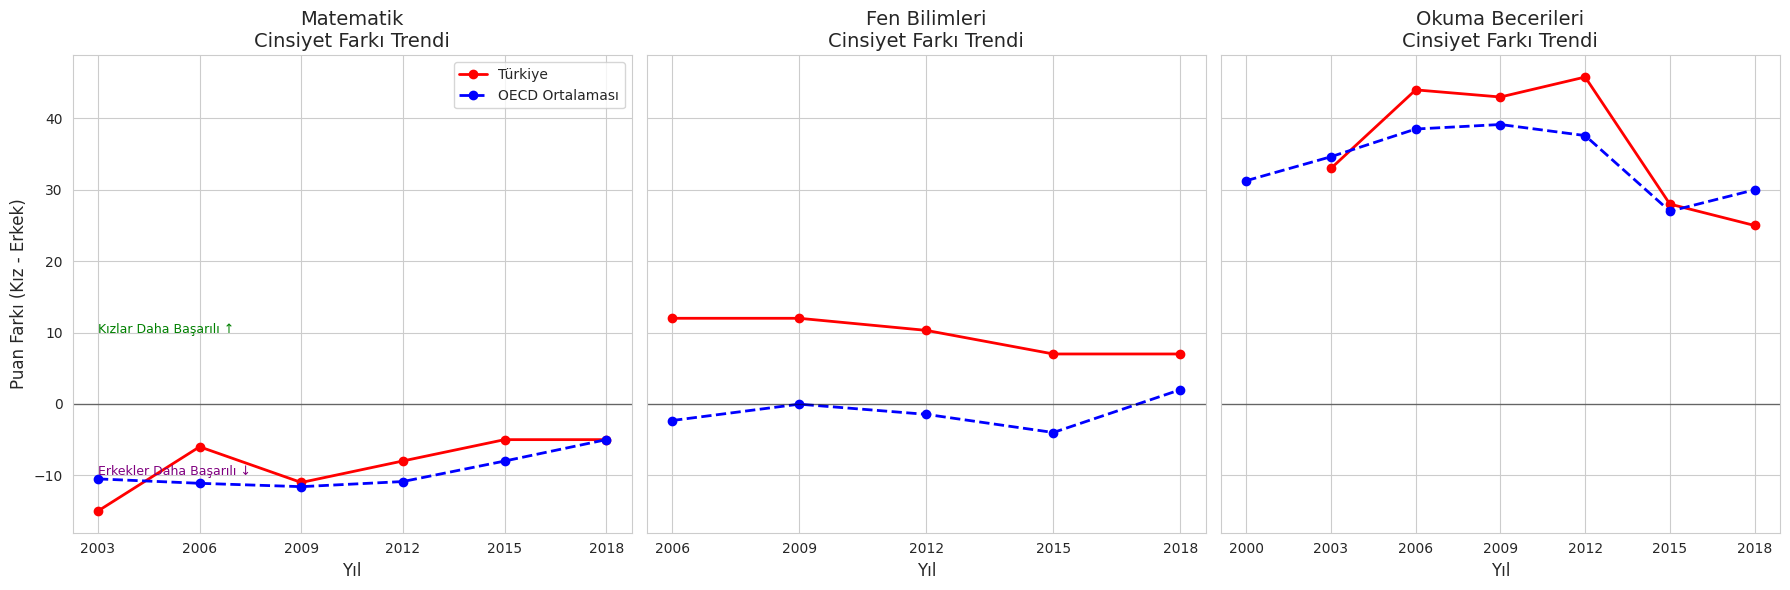

In [69]:
#ANALİZ_1
#FIRSAT EŞİTLİĞİ TRENDİ (CİNSİYET FARKI)

# İlgilendiğimiz konumlar ve cinsiyetler
target_locations = ['TUR', 'OAVG']
target_subjects = ['BOY', 'GIRL']
df_filtered = df[(df['LOCATION'].isin(target_locations)) & (df['SUBJECT'].isin(target_subjects))]

# Her bir gösterge (Matematik, Fen, Okuma) için puanları gruplayıp hesapladık
df_grouped = df_filtered.groupby(['INDICATOR', 'TIME', 'LOCATION', 'SUBJECT'])['Value'].mean().unstack()

# Cinsiyet Farkını Hesapladık (Kız - Erkek)
df_grouped['Gender_Gap'] = df_grouped['GIRL'] - df_grouped['BOY']

# Çizim için veriyi düzenledik
df_gap = df_grouped['Gender_Gap'].reset_index()

# Göstergeler ve Başlıkları
indicators = {
    'PISAMATH': 'Matematik',
    'PISASCIENCE': 'Fen Bilimleri',
    'PISAREAD': 'Okuma Becerileri'
}

# Grafik alanını oluşturduk (1 satır, 3 sütun)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (indicator, title) in enumerate(indicators.items()):
    ax = axes[i]

    # İlgili gösterge verisini seçtik
    data = df_gap[df_gap['INDICATOR'] == indicator]
    plot_data = data.pivot(index='TIME', columns='LOCATION', values='Gender_Gap')

    # Türkiye Çizimi
    if 'TUR' in plot_data.columns:
        ax.plot(plot_data.index, plot_data['TUR'], marker='o', label='Türkiye', linewidth=2, color='red')

    # OECD Ortalaması Çizimi
    if 'OAVG' in plot_data.columns:
        ax.plot(plot_data.index, plot_data['OAVG'], marker='o', label='OECD Ortalaması', linewidth=2, linestyle='--', color='blue')

    # Eşitlik Çizgisi
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Ayarlar
    ax.set_title(f'{title}\nCinsiyet Farkı Trendi', fontsize=14)
    ax.set_xlabel('Yıl', fontsize=12)
    ax.grid(True)
    ax.set_xticks(plot_data.index)

    # İlk grafiğe eksen etiketi ve açıklama ekleyelim
    if i == 0:
        ax.set_ylabel('Puan Farkı (Kız - Erkek)', fontsize=12)
        ax.legend()
        # Yönlendirme yazıları
        ax.text(plot_data.index.min(), 10, 'Kızlar Daha Başarılı ↑', fontsize=9, color='green')
        ax.text(plot_data.index.min(), -10, 'Erkekler Daha Başarılı ↓', fontsize=9, color='purple')

plt.tight_layout()
plt.show()

Bu grafikte;

0 Çizgisi: Cinsiyetler arası tam eşitliği gösterir.

Pozitif Değerler: Kız öğrencilerin daha başarılı olduğu durumu ifade eder.

Negatif Değerler: Erkek öğrencilerin daha başarılı olduğu durumu ifade eder.









Okuma Becerileri (En Büyük Fark):

Hem Türkiye'de hem OECD'de kız öğrenciler, okuma becerilerinde erkeklerden çok daha başarılıdır (Grafikte pozitif yönde büyük bir fark var).

Türkiye'deki fark (kırmızı çizgi), genellikle OECD ortalamasının (mavi çizgi) altında seyretse de (yani fark daha az olsa da), 2018 yılında OECD seviyesine yaklaşmıştır. Kızlar okumada yaklaşık 25-30 puan öndedir.

Matematik (Erkekler Önde):

Matematik alanı, erkeklerin genellikle daha başarılı olduğu bir alandır (Negatif değerler).

Türkiye'de 2003-2012 arasında erkekler matematikte daha başarılıyken (sıfırın altında), 2015 ve sonrasında fark kapanmış ve neredeyse eşitlik sağlanmıştır (kırmızı çizgi 0'a çok yakın). OECD genelinde ise erkeklerin ufak bir üstünlüğü devam etmektedir.

Fen Bilimleri (Kızlar Öne Geçiyor):

Fen bilimlerinde OECD ortalaması genellikle 0 civarında (eşitlik) seyrederken, Türkiye'de ilginç bir değişim yaşanmıştır.

Türkiye'de 2006-2012 yıllarında eşitliğe yakın veya hafif erkek üstünlüğü varken, 2015 ve özellikle 2018 yıllarında kız öğrencilerin başarısı belirgin şekilde artmış ve fark pozitif yönde açılmıştır. Kızlar Fen bilimlerinde erkekleri geçmiştir.

/tmp/ipython-input-3964743499.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


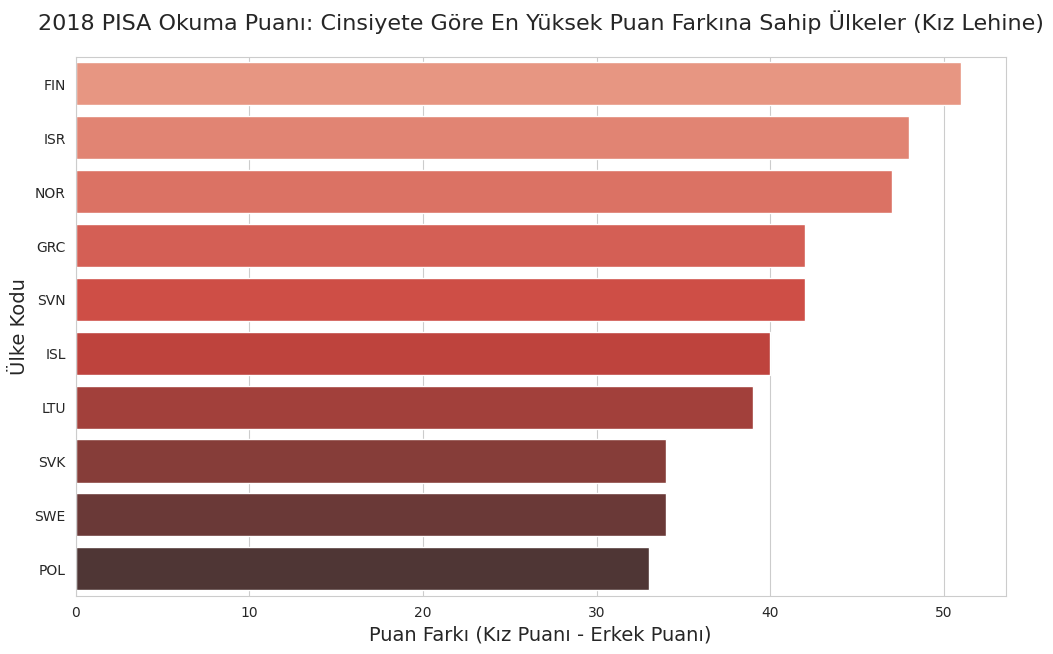

In [70]:
#ANALİZ_2
#2018 PISA OKUMA PUANI CİNSİYET FARKI ANALİZİ


# 2018 Yılı Verisini Oluşturmak için df_2018 değişkenini burada tanımlıyoruz
df_2018 = df[df['TIME'] == 2018]

# Sadece Okuma (READ) verisini aldık.
okuma_farki = df_2018[df_2018['INDICATOR'] == 'PISAREAD']

# Cinsiyetleri pivot edip sonrasında farkı (Kız - Erkek) hesapladık
okuma_farki_pivot = okuma_farki.pivot_table(index='LOCATION', columns='SUBJECT', values='Value')
okuma_farki_pivot['Fark (GIRL - BOY)'] = okuma_farki_pivot['GIRL'] - okuma_farki_pivot['BOY']

# En büyük 10 Okuma Farkına sahip ülkeyi bulduk
top_10_okuma_farki = okuma_farki_pivot.sort_values(by='Fark (GIRL - BOY)', ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 7))
sns.barplot(
    x='Fark (GIRL - BOY)',
    y='LOCATION',
    data=top_10_okuma_farki,
    palette=sns.color_palette("Reds_d", len(top_10_okuma_farki))
)

plt.title('2018 PISA Okuma Puanı: Cinsiyete Göre En Yüksek Puan Farkına Sahip Ülkeler (Kız Lehine)', pad=20)
plt.xlabel('Puan Farkı (Kız Puanı - Erkek Puanı)')
plt.ylabel('Ülke Kodu')
plt.show()

Bu analiz, PISA sınavının "Okuma Becerileri" alanında küresel ölçekte bilinen "Kız Öğrenciler Lehine Başarı Farkı" fenomeninin en uç örneklerini göstermektedir.

Finlandiya (FIN) Örneği ve Makasın Boyutu:

Listede zirvede 51 puanlık devasa bir farkla Finlandiya yer almaktadır. PISA standartlarına göre yaklaşık 40 puanlık bir fark, 1 yıllık örgün eğitim süresine denk gelmektedir.

Bu durum, Finlandiya'daki kız öğrencilerin, okuma anlama becerilerinde aynı sınıftaki erkek arkadaşlarından 1 yıl daha ileride olduğunu göstermektedir ki bu, eğitim politikaları açısından alarm verici bir durumdur.

Kuzey Ülkeleri (Nordic) Paradoksu:

Grafikte dikkat çeken en önemli detay; Finlandiya, Norveç (NOR), İzlanda (ISL) ve İsveç (SWE) gibi toplumsal cinsiyet eşitliğinin en yüksek olduğu ülkelerin, eğitim çıktılarında en yüksek eşitsizliği (kızlar lehine) barındırıyor olmasıdır.

Bu durum literatürde bazen "Cinsiyet Eşitliği Paradoksu" olarak tartışılmaktadır; refah düzeyi ve özgürlük arttıkça, cinsiyetlerin ilgi alanları ve akademik tercihleri arasındaki farklar kapanmak yerine açılabilmektedir.

Genel Eğilim:

İlk 10'a giren tüm ülkelerde (İsrail, Slovenya, Yunanistan dahil) fark 33 puanın üzerindedir. Bu, söz konusu ülkelerde erkek öğrencilerin okuma-anlama konusunda ciddi bir dezavantaj veya motivasyon kaybı yaşadığını, eğitim sisteminin okuma modüllerinin kız öğrencilere daha fazla hitap ediyor olabileceğini düşündürmektedir.

Özetle: Bu grafik, eğitimde fırsat eşitliği tartışılırken genellikle odaklanılan "Kızların okullaşması" sorununun ötesinde, gelişmiş ülkelerde "Erkeklerin okuma becerilerindeki gerileyişi" gibi yeni ve ciddi bir sorunun varlığını kanıtlar niteliktedir.

In [71]:
#ANALİZ_3
# PISA VERİ SETİ: ÜLKE BAZLI VERİ DAĞILIMI VE KATILIM YOĞUNLUĞU


# Konum bazında veri sayısı (TIME)
konum_bilgileri = df['LOCATION'].value_counts()
print(konum_bilgileri)

LOCATION
AUS     54
BEL     54
CAN     54
DNK     54
CZE     54
FIN     54
FRA     54
ISL     54
DEU     54
GRC     54
HUN     54
ITA     54
IRL     54
JPN     54
KOR     54
BRA     54
MEX     54
NOR     54
NZL     54
POL     54
PRT     54
SWE     54
CHE     54
IDN     54
LUX     53
SVK     51
NLD     51
USA     51
TUR     51
ESP     51
OAVG    49
CHL     48
ISR     48
RUS     47
AUT     45
GBR     45
EST     45
SVN     45
LVA     30
COL     18
SGP      9
HKG      9
PER      9
TWN      9
MAC      9
CRI      9
LTU      9
Name: count, dtype: int64


/tmp/ipython-input-750271150.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ulke_sayilari.index, y=ulke_sayilari.values, palette='viridis')


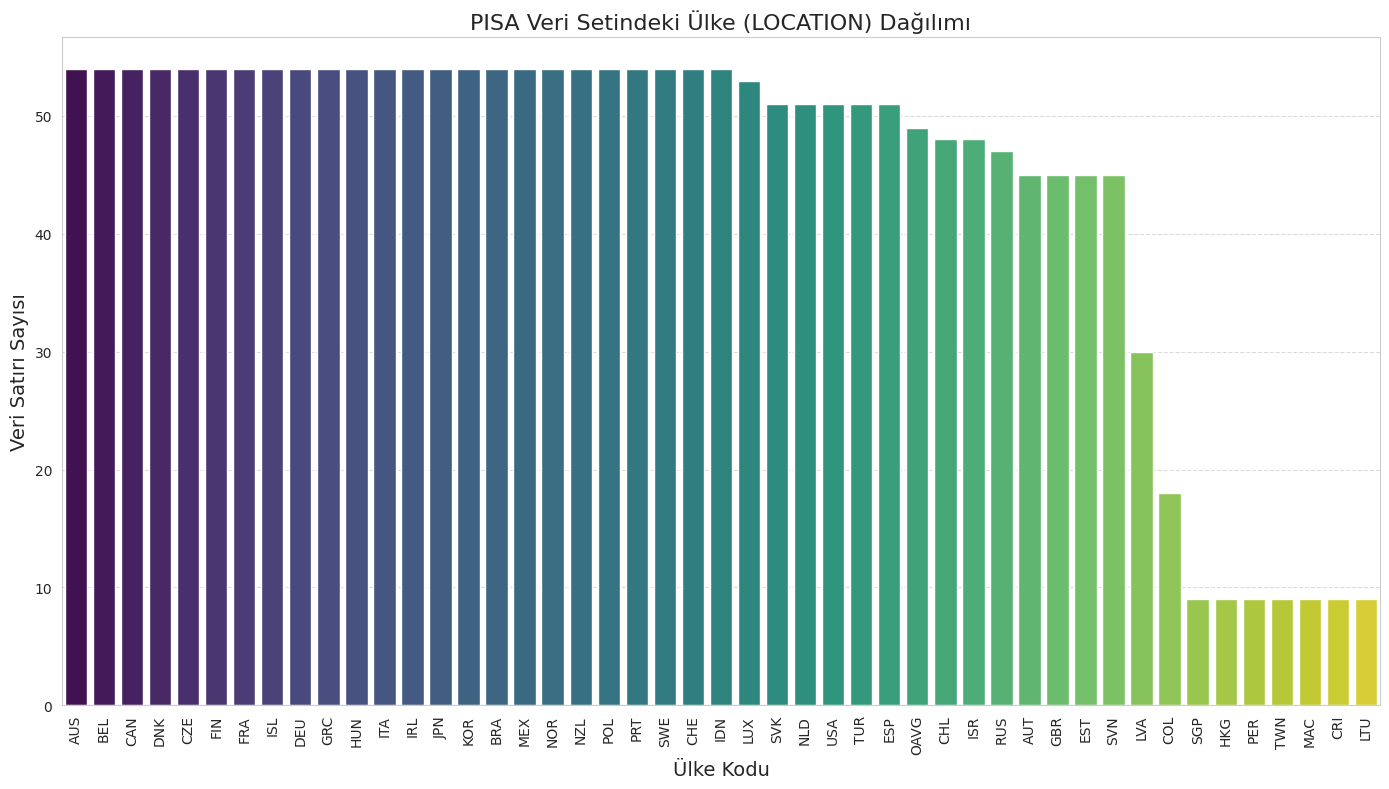

In [72]:
# ulke_sayilari değişkenini tekrar hesaplıyoruz.
ulke_sayilari = df['LOCATION'].value_counts()

plt.figure(figsize=(14, 8))
sns.barplot(x=ulke_sayilari.index, y=ulke_sayilari.values, palette='viridis')
plt.title('PISA Veri Setindeki Ülke (LOCATION) Dağılımı', fontsize=16)
plt.xlabel('Ülke Kodu', fontsize=14)
plt.ylabel('Veri Satırı Sayısı', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Veri setimizdeki ülkelerin PISA puanları incelenirken, grafikte görüldüğü gibi bazı ülkelerin diğerlerine göre çok daha az gözlem içermesi, elde edeceğimiz sonuçların güvenirliğini ve genellenebilirliğini doğrudan etkiler. Örneğin, 9 veri satırı olan bir ülkenin ortalama puanı veya trendi hakkında yapacağımız çıkarımlar, 54 veri satırı olan bir ülkeninkine göre çok daha az sağlam olacaktır.Bu durum, ülkeler arası karşılaştırmalar yaparken sonuçları daha temkinli yorumlamamız gerektiğini ve az veriye sahip ülkeler için çıkarımların sınırlı kalabileceğini gösterir. Kısacası, veri setinin bu yapısı, her ülkeye eşit derecede güvenemeyeceğimizi bize gösteriyor.

In [73]:
#ANALİZ_4
#2018 PISA: ÜLKELERİN GENEL BAŞARI SIRALAMASI


df_2018_tot = df[(df['TIME'] == 2018) & (df['SUBJECT'] == 'TOT')].copy()
country_avg_scores = df_2018_tot.groupby('LOCATION')['Value'].mean().reset_index()

print("\n--- 2018 Yılı ve 'TOT' Konusu İçin Ülke Bazında Ortalama PISA Puanları ---")
print(country_avg_scores.head())


--- 2018 Yılı ve 'TOT' Konusu İçin Ülke Bazında Ortalama PISA Puanları ---
  LOCATION       Value
0      AUS  499.000000
1      AUT  491.000000
2      BEL  500.000000
3      BRA  400.333333
4      CAN  516.666667


/tmp/ipython-input-1395057652.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='LOCATION', y='Value', data=country_avg_scores_sorted, palette='viridis')


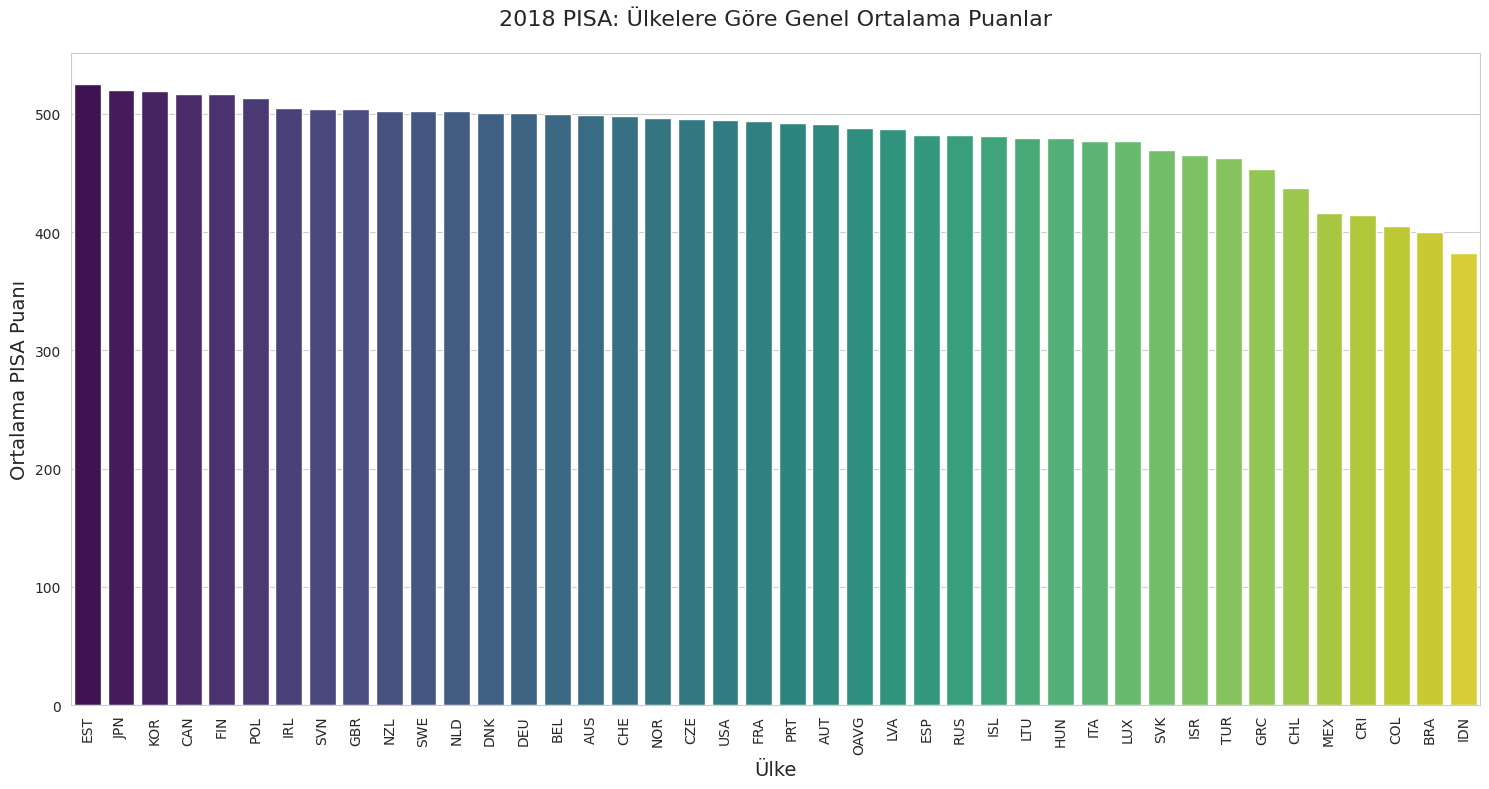

In [74]:
country_avg_scores_sorted = country_avg_scores.sort_values(by='Value', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x='LOCATION', y='Value', data=country_avg_scores_sorted, palette='viridis')

plt.title('2018 PISA: Ülkelere Göre Genel Ortalama Puanlar', pad=20)
plt.xlabel('Ülke')
plt.ylabel('Ortalama PISA Puanı')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Bu grafik, 2018 yılı PISA sonuçlarına göre ülkelerin Matematik, Fen ve Okuma alanlarındaki genel ortalama performanslarını büyükten küçüğe sıralamaktadır. Verilerden şu temel çıkarımlar yapılabilir:

Zirvedeki Hakimiyet (Asya ve Estonya Başarısı):

Sıralamanın en tepesinde Estonya (EST), Japonya (JPN) ve Güney Kore (KOR) yer almaktadır. Estonya'nın Avrupa'daki geleneksel eğitim devi Finlandiya'yı geçerek zirveye yerleşmesi, PISA 2018'in en dikkat çekici sonucudur.

Bu ülkeler 520 puan bandında seyrederek, küresel eğitim standartlarını belirleyen lider grup konumundadır.

OECD Ortalamasının Konumu:

OECD Ortalaması (OAVG), yaklaşık 488 puan ile listenin orta sıralarında (42 ülke içinde 24. sırada) bir referans noktası oluşturmaktadır. Bu çizginin üzerindeki ülkeler "ortalamanın üstünde başarılı", altındakiler ise "geliştirilmesi gereken" kategorisinde değerlendirilebilir.

Türkiye'nin Yeri ve Durumu:

Türkiye, yaklaşık 463 puanla listenin alt yarısında, 35. sırada yer almaktadır.

Türkiye'nin konumu; Yunanistan, Şili ve Slovakya gibi ülkelerle benzer bir bandı paylaşırken; OECD ortalamasının (488 puan) yaklaşık 25 puan (yarım eğitim yılına denk) gerisindedir.

Buna rağmen en alt gruptaki (Endonezya, Brezilya, Kolombiya) ülkelerden belirgin şekilde ayrışarak, orta-alt grupta kendine yer bulmuştur.

Makasın Genişliği:

Listenin en başı (Estonya ~525 puan) ile en sonu (Endonezya ~382 puan) arasında 140 puanı aşan devasa bir fark bulunmaktadır.

Bu fark, PISA ölçeğinde yaklaşık 3-4 yıllık örgün eğitim farkına eşdeğerdir. Yani en başarılı ülkedeki 15 yaşındaki bir öğrenci, en başarısız ülkedeki yaşıtına göre akademik olarak 3-4 yıl daha ileridedir.

Özet Sonuç: Grafik, eğitimde küresel rekabetin boyutunu ve ülkeler arasındaki gelişmişlik farkının eğitim çıktılarına nasıl yansıdığını net bir şekilde ortaya koymaktadır. Asya ülkeleri ve Estonya'nın liderliği sürerken, Türkiye gibi gelişmekte olan ülkeler OECD ortalamasını yakalamak için hala ciddi bir mesafe katetmek zorundadır.

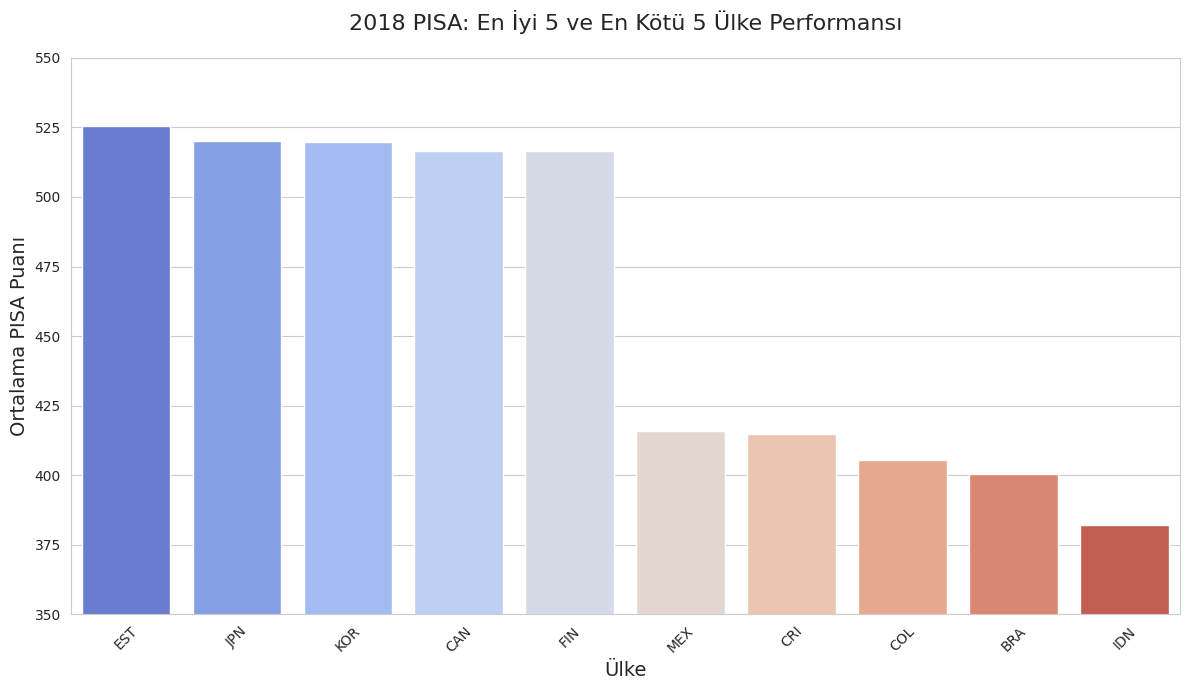

In [75]:
#ANALİZ_5
#2018 PISA SONUÇLARINA GÖRE EN YÜKSEK VE EN DÜŞÜK PERFORMANSLI ÜLKELERİN KARŞILAŞTIRMALI ANALİZİ


top_5_countries = country_avg_scores_sorted.head(5)
bottom_5_countries = country_avg_scores_sorted.tail(5)

# Görselleştirme için ilk 5 ve son 5'i birleştirdik.
comparison_countries = pd.concat([top_5_countries, bottom_5_countries])

plt.figure(figsize=(12, 7))
sns.barplot(
    x='LOCATION',
    y='Value',
    data=comparison_countries,
    palette='coolwarm',
    hue='LOCATION',
    legend=False
)

plt.title('2018 PISA: En İyi 5 ve En Kötü 5 Ülke Performansı', pad=20)
plt.xlabel('Ülke')
plt.ylabel('Ortalama PISA Puanı')
plt.ylim(350, 550) # Daha iyi karşılaştırma yapabilmek için tutarlı bir y ekseni aralığı ayarladık
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Genel Performans Dağılımı:** Ülkeler arasında PISA puanlarında belirgin farklılıklar gözlenmektedir. Bazı ülkeler, genel olarak yüksek puanlar elde ederken, bazıları uluslararası ortalamanın oldukça altında kalmıştır.

**En Başarılı Ülkeler:** İlk 5'te yer alan ülkeler (Estonya, Japonya, Kore, Kanada, Finlandiya) PISA'da sürekli olarak yüksek performans gösteren ülkeler arasında yer almaktadır. Bu ülkeler, eğitim sistemlerinin öğrencilerini üç ana alanda (Matematik, Okuma, Fen) güçlü bir şekilde desteklediğini göstermektedir.

**En Düşük Performans Gösteren Ülkeler:** Son 5'te yer alan ülkeler (Meksika, Kosta Rika, Kolombiya, Brezilya, Endonezya) ise PISA puanları açısından daha düşük bir seviyede kalmıştır. Bu ülkelerin, eğitim sistemlerinde öğrencilerin temel becerilerini geliştirmeye yönelik daha fazla yatırım ve stratejiye ihtiyaç duyduğu söylenebilir.

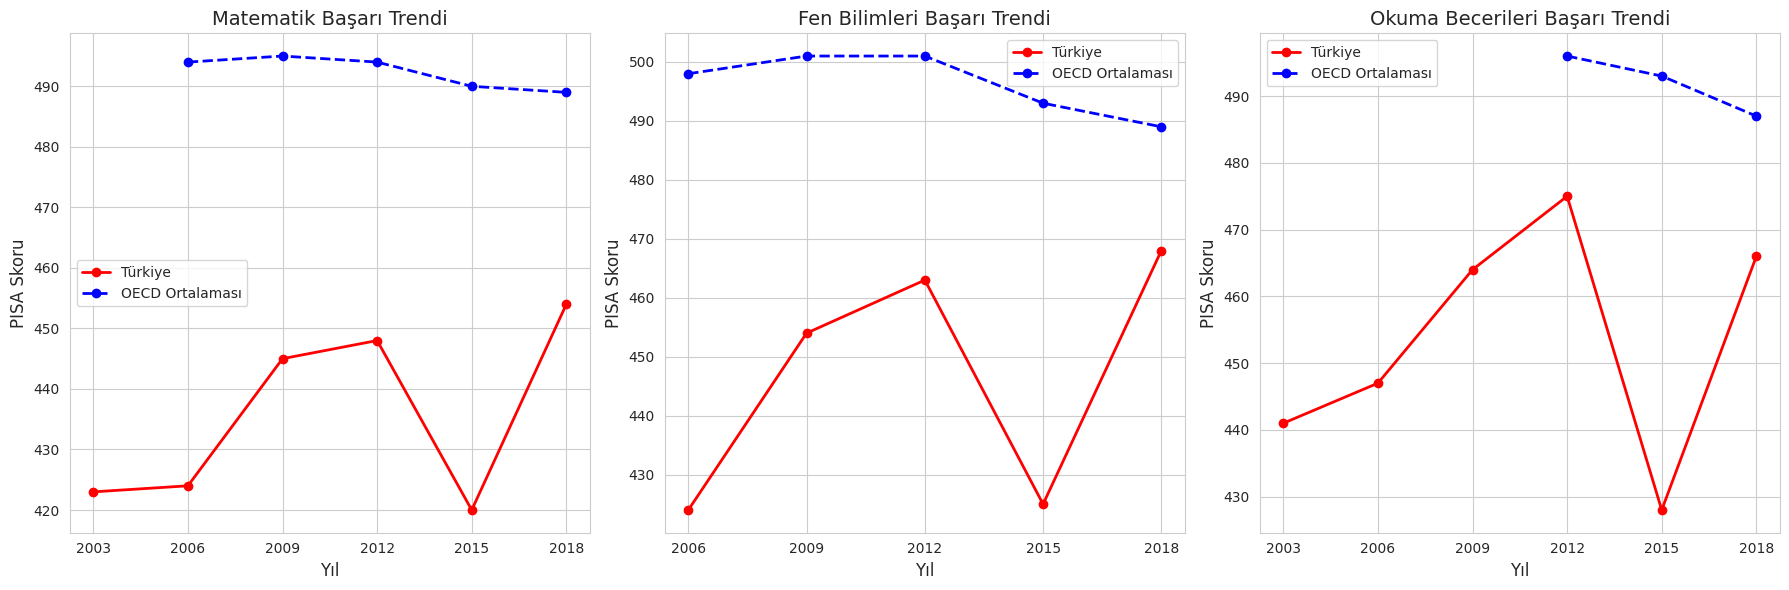

In [76]:
#ANALİZ_6
#GENEL BAŞARI TRENDİ (TÜRKİYE VS OECD)


# İlgilendiğimiz konumlar (Türkiye ve OECD Ortalaması) ve genel toplam (TOT)
target_locations = ['TUR', 'OAVG']
df_filtered = df[(df['LOCATION'].isin(target_locations)) & (df['SUBJECT'] == 'TOT')]

# Göstergeler ve Türkçe karşılıkları
indicators = {
    'PISAMATH': 'Matematik',
    'PISASCIENCE': 'Fen Bilimleri',
    'PISAREAD': 'Okuma Becerileri'
}

# Grafik alanını oluşturduk (1 satır, 3 sütun)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (indicator, title) in enumerate(indicators.items()):
    ax = axes[i]

    # İlgili gösterge için veriyi filtreledik
    df_ind = df_filtered[df_filtered['INDICATOR'] == indicator]

    # Çizim için veriyi düzenledik (pivot)
    df_plot = df_ind.pivot(index='TIME', columns='LOCATION', values='Value')

    # Türkiye çizimi
    if 'TUR' in df_plot.columns:
        ax.plot(df_plot.index, df_plot['TUR'], marker='o', label='Türkiye', linewidth=2, color='red')

    # OECD Ortalaması çizimi
    if 'OAVG' in df_plot.columns:
        ax.plot(df_plot.index, df_plot['OAVG'], marker='o', label='OECD Ortalaması', linewidth=2, linestyle='--', color='blue')

    # Eksen ve başlık ayarları
    ax.set_title(f'{title} Başarı Trendi', fontsize=14)
    ax.set_xlabel('Yıl', fontsize=12)
    ax.set_ylabel('PISA Skoru', fontsize=12)
    ax.grid(True)
    ax.legend()

    # Yılların eksende tam görünmesi için
    ax.set_xticks(df_plot.index)

plt.tight_layout()
plt.show()

Grafiklerdeki verileri incelediğimizde şu temel çıkarımları yapabiliriz:

1.  **Genel Seviye Farkı:** Tüm branşlarda (Matematik, Fen ve Okuma) Türkiye'nin ortalama puanları, OECD ortalamasının altında seyretmektedir. Ancak bu fark yıllara göre değişkenlik göstermektedir.
2.  **2003-2012 Yükseliş Dönemi:** Türkiye, özellikle 2003'ten 2012 yılına kadar olan süreçte genel bir yükseliş trendi yakalamıştır. Örneğin, Matematik puanı 423'ten 448'e, Fen puanı (2006-2012 arası) 424'ten 463'e çıkmıştır. Bu dönemde OECD ortalaması ile olan makasın bir miktar daraldığı görülmektedir.
3.  **2015 Düşüşü:** 2015 yılı verilerinde Türkiye'nin puanlarında üç alanda da belirgin bir düşüş gözlemlenmektedir (Örneğin Matematik 448'den 420'ye gerilemiştir). Bu düşüş trendi OECD ortalamasında da hafifçe görülse de Türkiye'deki düşüş daha keskindir.
4.  **2018 Toparlanması:** 2018 yılında ise tekrar bir toparlanma süreci başlamış, puanlar 2015 seviyesinin üzerine çıkarak 2012 seviyelerine yaklaşmıştır (Örneğin Fen bilimlerinde 468 puana ulaşılmıştır).

Özetle; Türkiye PISA skorlarında dalgalı bir seyir izlemekte olup, 2012 yılına kadar süren iyileşme trendi 2015'te kesintiye uğrasa da 2018 itibarıyla tekrar yukarı yönlü bir ivme kazanmıştır.

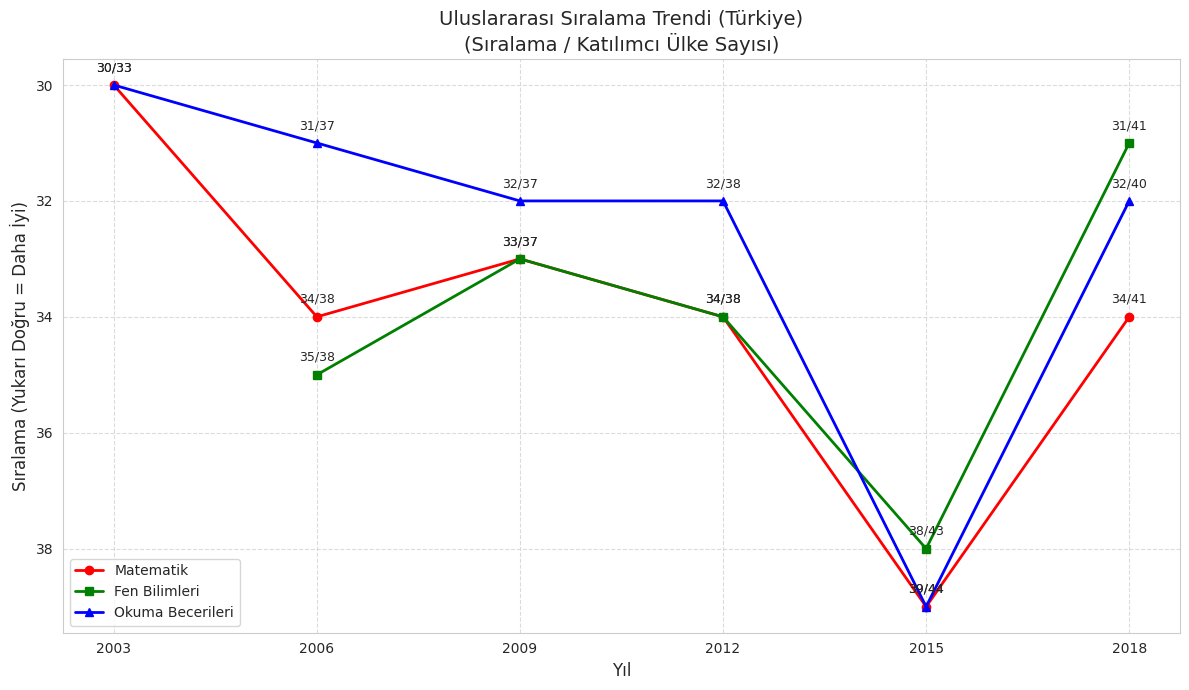

In [77]:
#ANALİZ_7
#ULUSLARARASI SIRALAMA TRENDİ

# Toplam puan (TOT) ve OECD ortalaması (OAVG) hariç ülke verilerini filtreledik
df_filtered = df[(df['SUBJECT'] == 'TOT') & (df['LOCATION'] != 'OAVG')]

# Göstergeler
indicators = {
    'PISAMATH': 'Matematik',
    'PISASCIENCE': 'Fen Bilimleri',
    'PISAREAD': 'Okuma Becerileri'
}

# Sıralama verilerini saklamak için liste
ranking_data = []

for indicator, title in indicators.items():
    # İlgili göstergeyi seçtik
    df_ind = df_filtered[df_filtered['INDICATOR'] == indicator]

    # Yıllara göre döngü
    for year in df_ind['TIME'].unique():
        df_year = df_ind[df_ind['TIME'] == year].dropna(subset=['Value'])

        # Sıralama Hesaplama (Yüksek puan = 1. sıra)
        df_year = df_year.copy()
        df_year['Rank'] = df_year['Value'].rank(ascending=False, method='min')

        total_countries = len(df_year)

        # Türkiye'nin sırasını bulma
        turkey_data = df_year[df_year['LOCATION'] == 'TUR']

        if not turkey_data.empty:
            rank = turkey_data['Rank'].values[0]
            ranking_data.append({
                'Indicator': title,
                'Year': year,
                'Rank': int(rank),
                'Total_Countries': total_countries
            })

# Sonuçları DataFrame'e çevirdik
df_ranks = pd.DataFrame(ranking_data).sort_values('Year')

# Grafik Çizimi
plt.figure(figsize=(12, 7))

colors = {'Matematik': 'red', 'Fen Bilimleri': 'green', 'Okuma Becerileri': 'blue'}
markers = {'Matematik': 'o', 'Fen Bilimleri': 's', 'Okuma Becerileri': '^'}

for title in indicators.values():
    data = df_ranks[df_ranks['Indicator'] == title]
    plt.plot(data['Year'], data['Rank'], marker=markers[title], label=title, linewidth=2, color=colors[title])

    # Etiket ekleme: "Sıra / Toplam"
    for x, y, total in zip(data['Year'], data['Rank'], data['Total_Countries']):
        label = f"{y}/{total}"
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)

# Y eksenini ters çevirdik (1. sıra en üstte olsun)
plt.gca().invert_yaxis()

plt.title('Uluslararası Sıralama Trendi (Türkiye)\n(Sıralama / Katılımcı Ülke Sayısı)', fontsize=14)
plt.xlabel('Yıl', fontsize=12)
plt.ylabel('Sıralama (Yukarı Doğru = Daha İyi)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(df_ranks['Year'].unique())

plt.tight_layout()
plt.show()

Bu grafik, Türkiye'nin Matematik, Fen ve Okuma alanlarında katıldığı yıllardaki dünya sıralamasını göstermektedir.

Grafikteki her nokta "Sıralama / Toplam Katılımcı Ülke Sayısı" formatında etiketlenmiştir. Örneğin, "30/40" ifadesi, o yıl ilgili alanda sınav yapılan 40 ülke arasında 30. olunduğunu gösterir.

Grafiğe bakıldığında dikkat edilmesi gereken en önemli nokta, katılımcı ülke sayısının yıllar içinde değişmesidir.

Örneğin 2003 yılında yaklaşık 40 ülke varken, 2018 yılında bu sayı 70'in üzerine çıkmıştır.

Bu nedenle sıralama sayısının (rank) artması (grafikte aşağı gitmesi) her zaman başarısızlık anlamına gelmeyebilir; ancak genel trende bakıldığında Türkiye'nin sıralaması katılımcı ülke sayısındaki artışla paralel olarak değişmiş ve genellikle listenin orta-alt sıralarında yer almıştır.

2018 yılında bir toparlanma görülmekle birlikte, sıralamanın iyileşmesi (grafikte yukarı hareket) görecelidir.

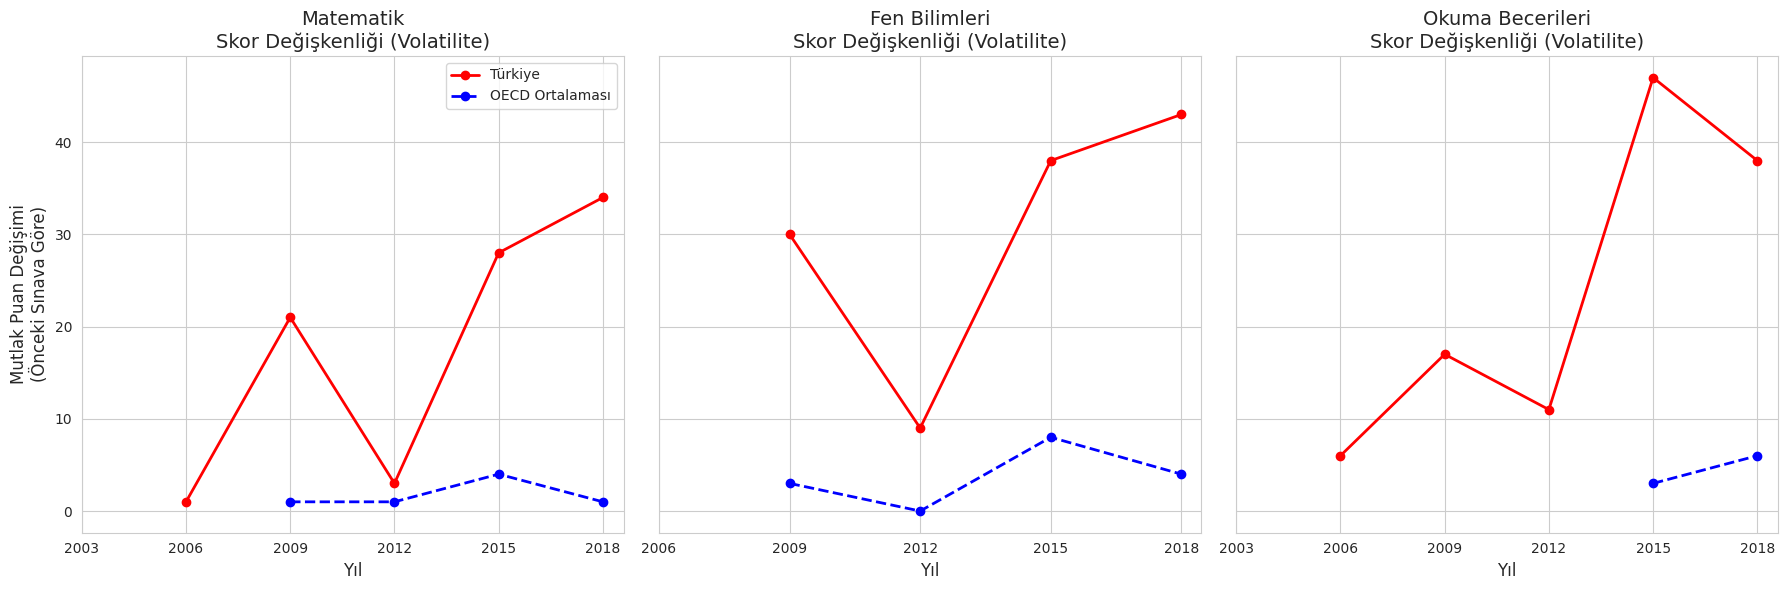

In [78]:
#ANALİZ_8
#YILLARA GÖRE SKOR DALGALANMASI (VOLATILITY) TRENDİ


# İlgilendiğimiz konumlar ve genel toplam
target_locations = ['TUR', 'OAVG']
df_filtered = df[(df['LOCATION'].isin(target_locations)) & (df['SUBJECT'] == 'TOT')]

# Göstergeler
indicators = {
    'PISAMATH': 'Matematik',
    'PISASCIENCE': 'Fen Bilimleri',
    'PISAREAD': 'Okuma Becerileri'
}

# Grafik alanı (1 satır, 3 sütun)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (indicator, title) in enumerate(indicators.items()):
    ax = axes[i]

    # İlgili gösterge için veriyi seçip sıraladık
    df_ind = df_filtered[df_filtered['INDICATOR'] == indicator].copy()
    df_ind = df_ind.sort_values(['LOCATION', 'TIME'])

    # Bir önceki döneme göre mutlak farkı hesapladık (Volatilite)
    df_ind['Diff'] = df_ind.groupby('LOCATION')['Value'].diff().abs()

    # Çizim için tabloyu düzenledik
    df_plot = df_ind.pivot(index='TIME', columns='LOCATION', values='Diff')

    # Türkiye Çizimi
    if 'TUR' in df_plot.columns:
        ax.plot(df_plot.index, df_plot['TUR'], marker='o', label='Türkiye', linewidth=2, color='red')

    # OECD Ortalaması Çizimi
    if 'OAVG' in df_plot.columns:
        ax.plot(df_plot.index, df_plot['OAVG'], marker='o', label='OECD Ortalaması', linewidth=2, linestyle='--', color='blue')

    # Ayarlar
    ax.set_title(f'{title}\nSkor Değişkenliği (Volatilite)', fontsize=14)
    ax.set_xlabel('Yıl', fontsize=12)
    ax.grid(True)
    ax.set_xticks(df_plot.index)

    if i == 0:
        ax.set_ylabel('Mutlak Puan Değişimi\n(Önceki Sınava Göre)', fontsize=12)
        ax.legend()

plt.tight_layout()
plt.show()

Bu grafiklerdeki yüksek değerler, puanların bir önceki sınava göre sert bir şekilde (aşağı veya yukarı) değiştiğini; düşük değerler ise istikrarı ifade eder.

Türkiye'nin Yüksek Volatilitesi: Grafiklerdeki kırmızı çizgiler (Türkiye), hemen hemen her dönemde mavi çizgilerin (OECD) üzerindedir. Bu, Türkiye'nin eğitim performansının OECD ortalamasına göre çok daha istikrarsız olduğunu göstermektedir. Puanlar bir dönemden diğerine sert düşüşler veya yükselişler yaşamaktadır.

2015 Kırılması: Özellikle 2015 yılındaki noktalara bakıldığında, Türkiye'nin üç alanda da çok yüksek bir değişim (bu durumda düşüş) yaşadığı ve volatilitenin zirve yaptığı görülmektedir (30-40 puanlık değişimler).

OECD İstikrarı: OECD ortalaması (mavi çizgi) genellikle 0-5 puan aralığında değişim göstererek çok daha stabil bir seyir izlemektedir.